# Image Segmentation: Vehicles from Space

Parameters to train:
- image segmentation threshold
- vehicle patch size
- vehicle patch ratio
- number of random seeds per image

In [5]:
%matplotlib inline

In [172]:
import cv2
import numpy as np
import pylab as plt
import math
from skimage import measure
import random

In [175]:
# function to split the images into tiles 360x480, 
# returns a list of smaller images and number of tiles in x y dimensions
tile_x = 360
tile_y = 480
    
def split_img(image):
    w,h = image.shape
    tile_x = 360
    tile_y = 480
    x = math.floor(w/tile_x)
    y = math.floor(h/tile_y)
    
    roi = []
    for i in range(x):
        for j in range(y):
            roi.append(image[i*tile_x:(i+1)*tile_x, j*tile_y:(j+1)*tile_y])

    return roi,x,y

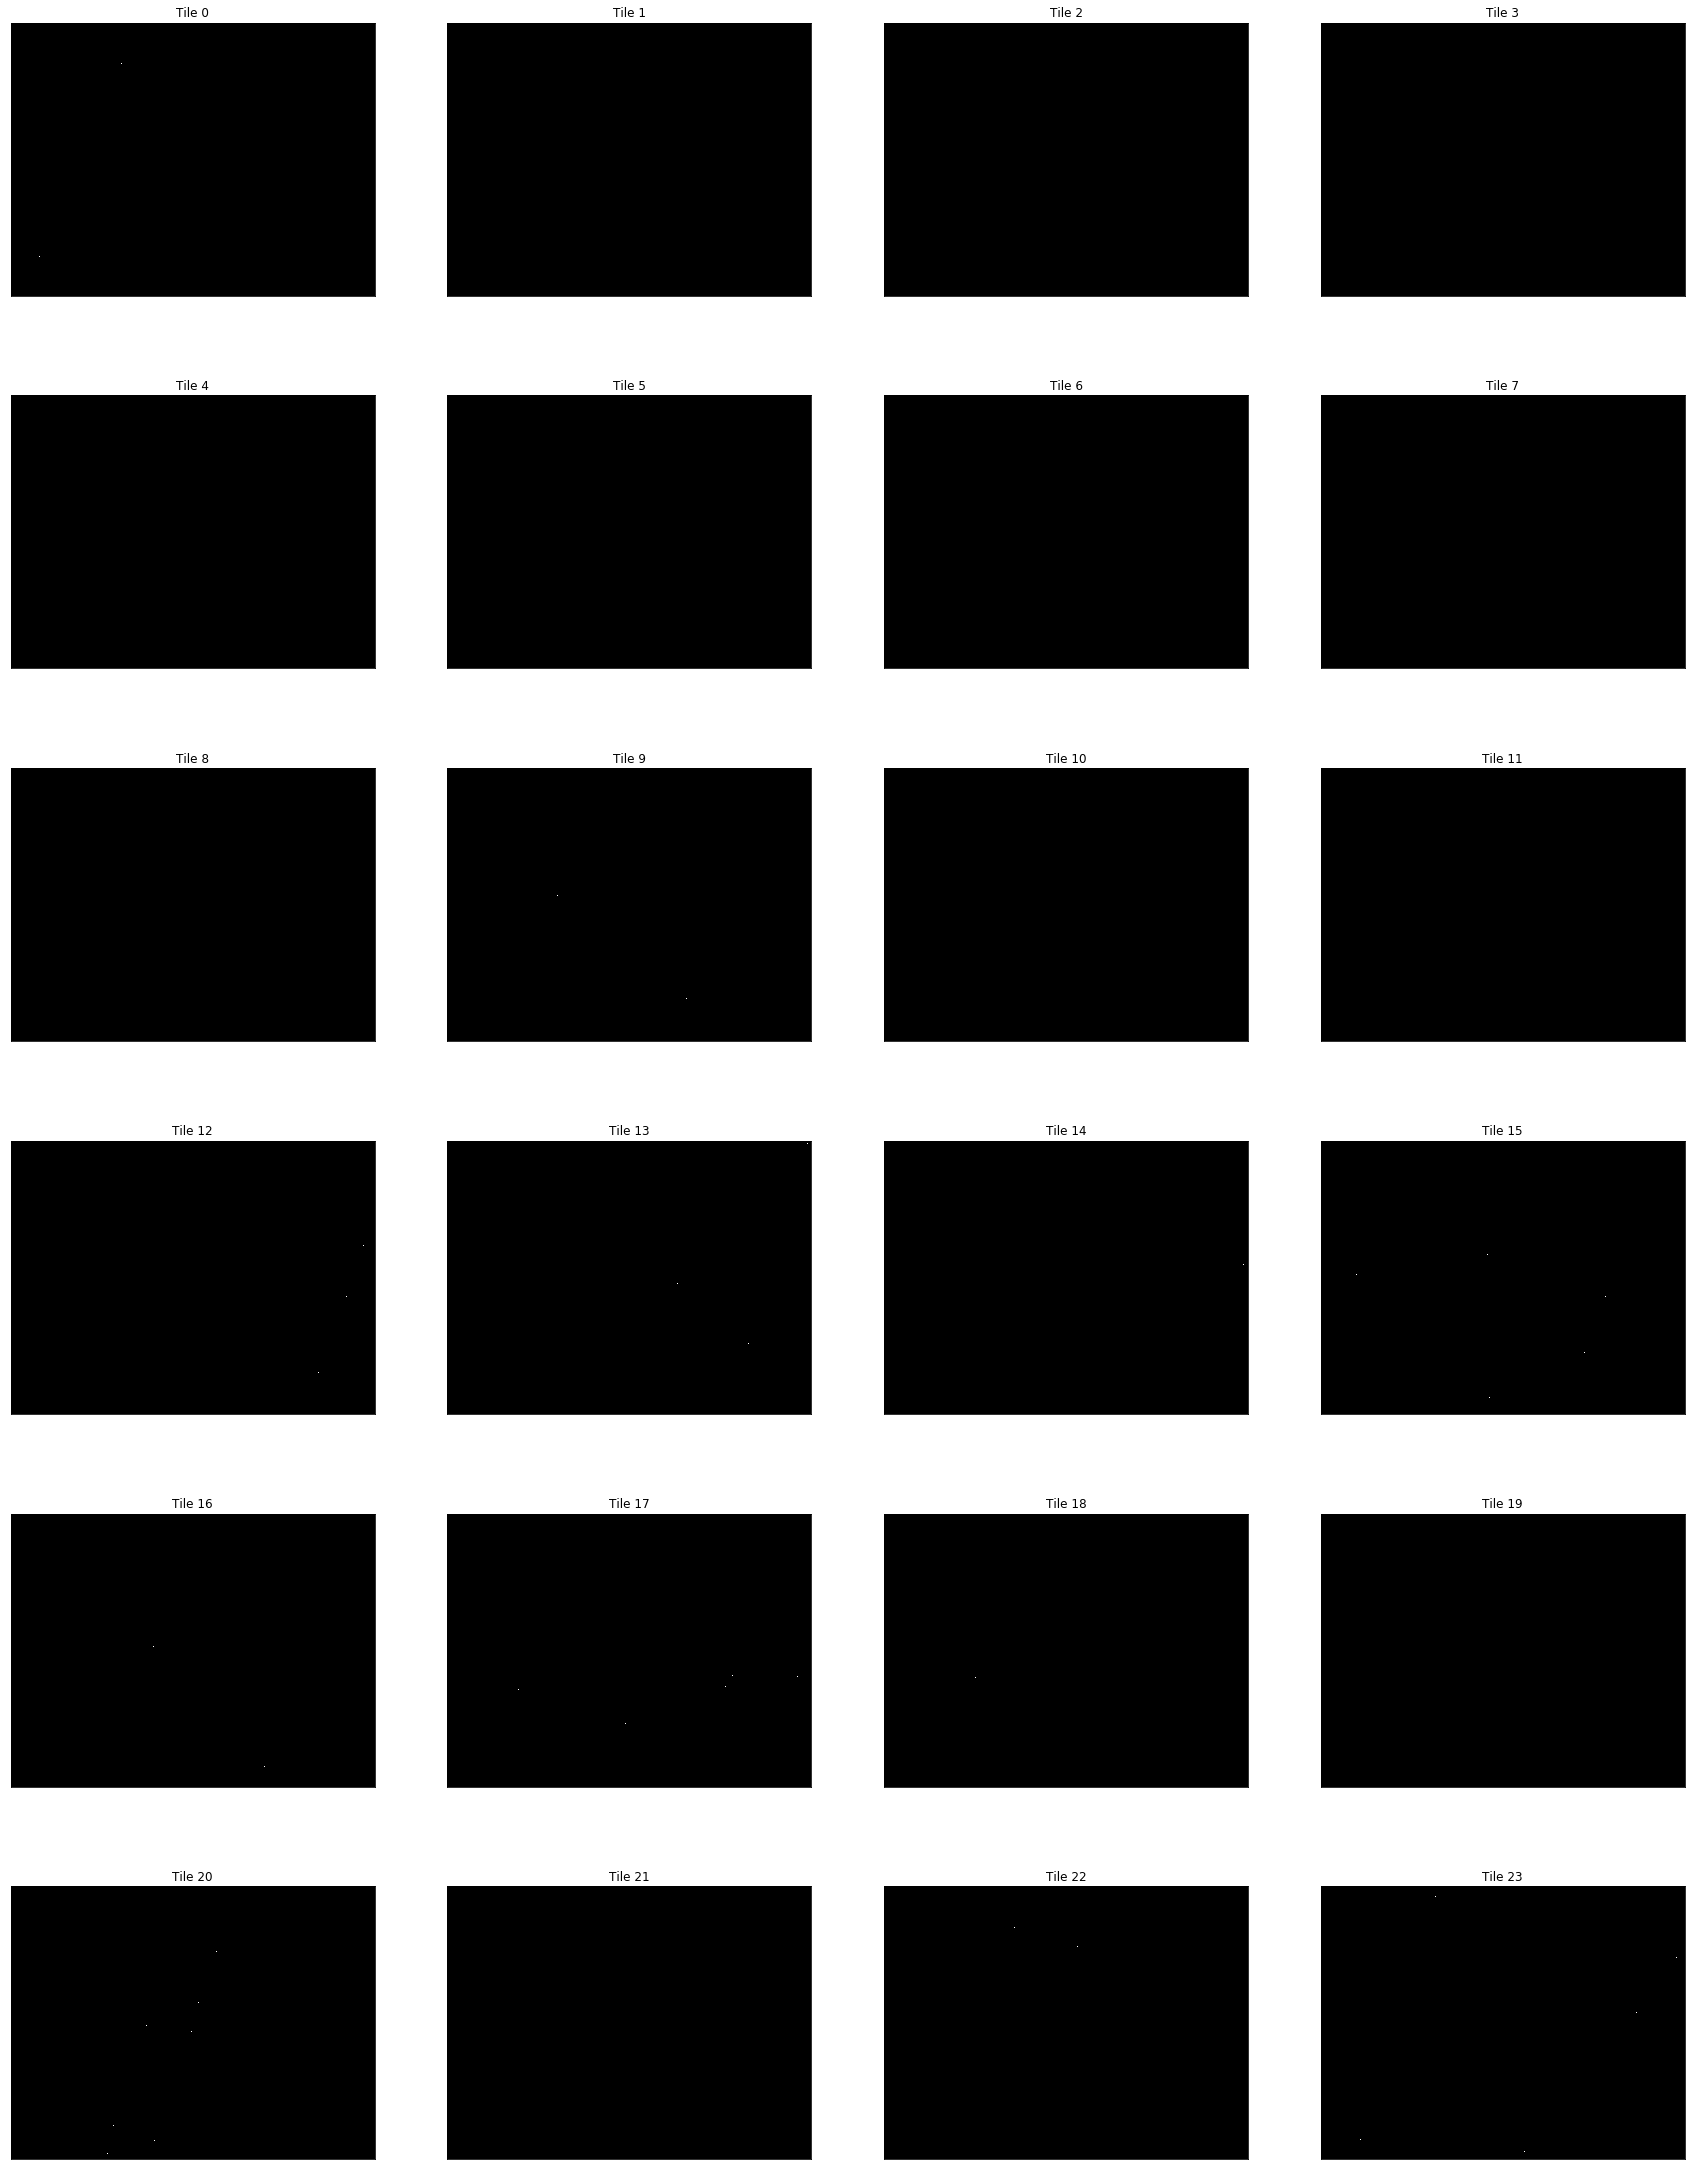

In [154]:
# preprocessing of truth data
# split positives (truth data)
truth = 'training_data/top_potsdam_2_10_RGB_Annotated_cars.tif'

# read in image(s) as greyscale and show
img_gray = cv2.imread(truth, 0)/76
truth,x,y = split_img(img_gray)

# show smaller images
plt.figure(figsize=(30,40))
for i in range(x*y):
    plt.subplot(x,y,i+1),plt.imshow(truth[i],'gray')
    plt.title("Tile "+str(i))
    plt.xticks([]),plt.yticks([])
plt.show()

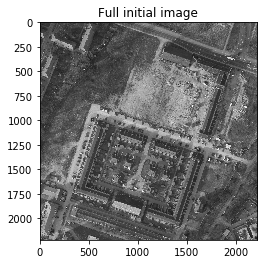

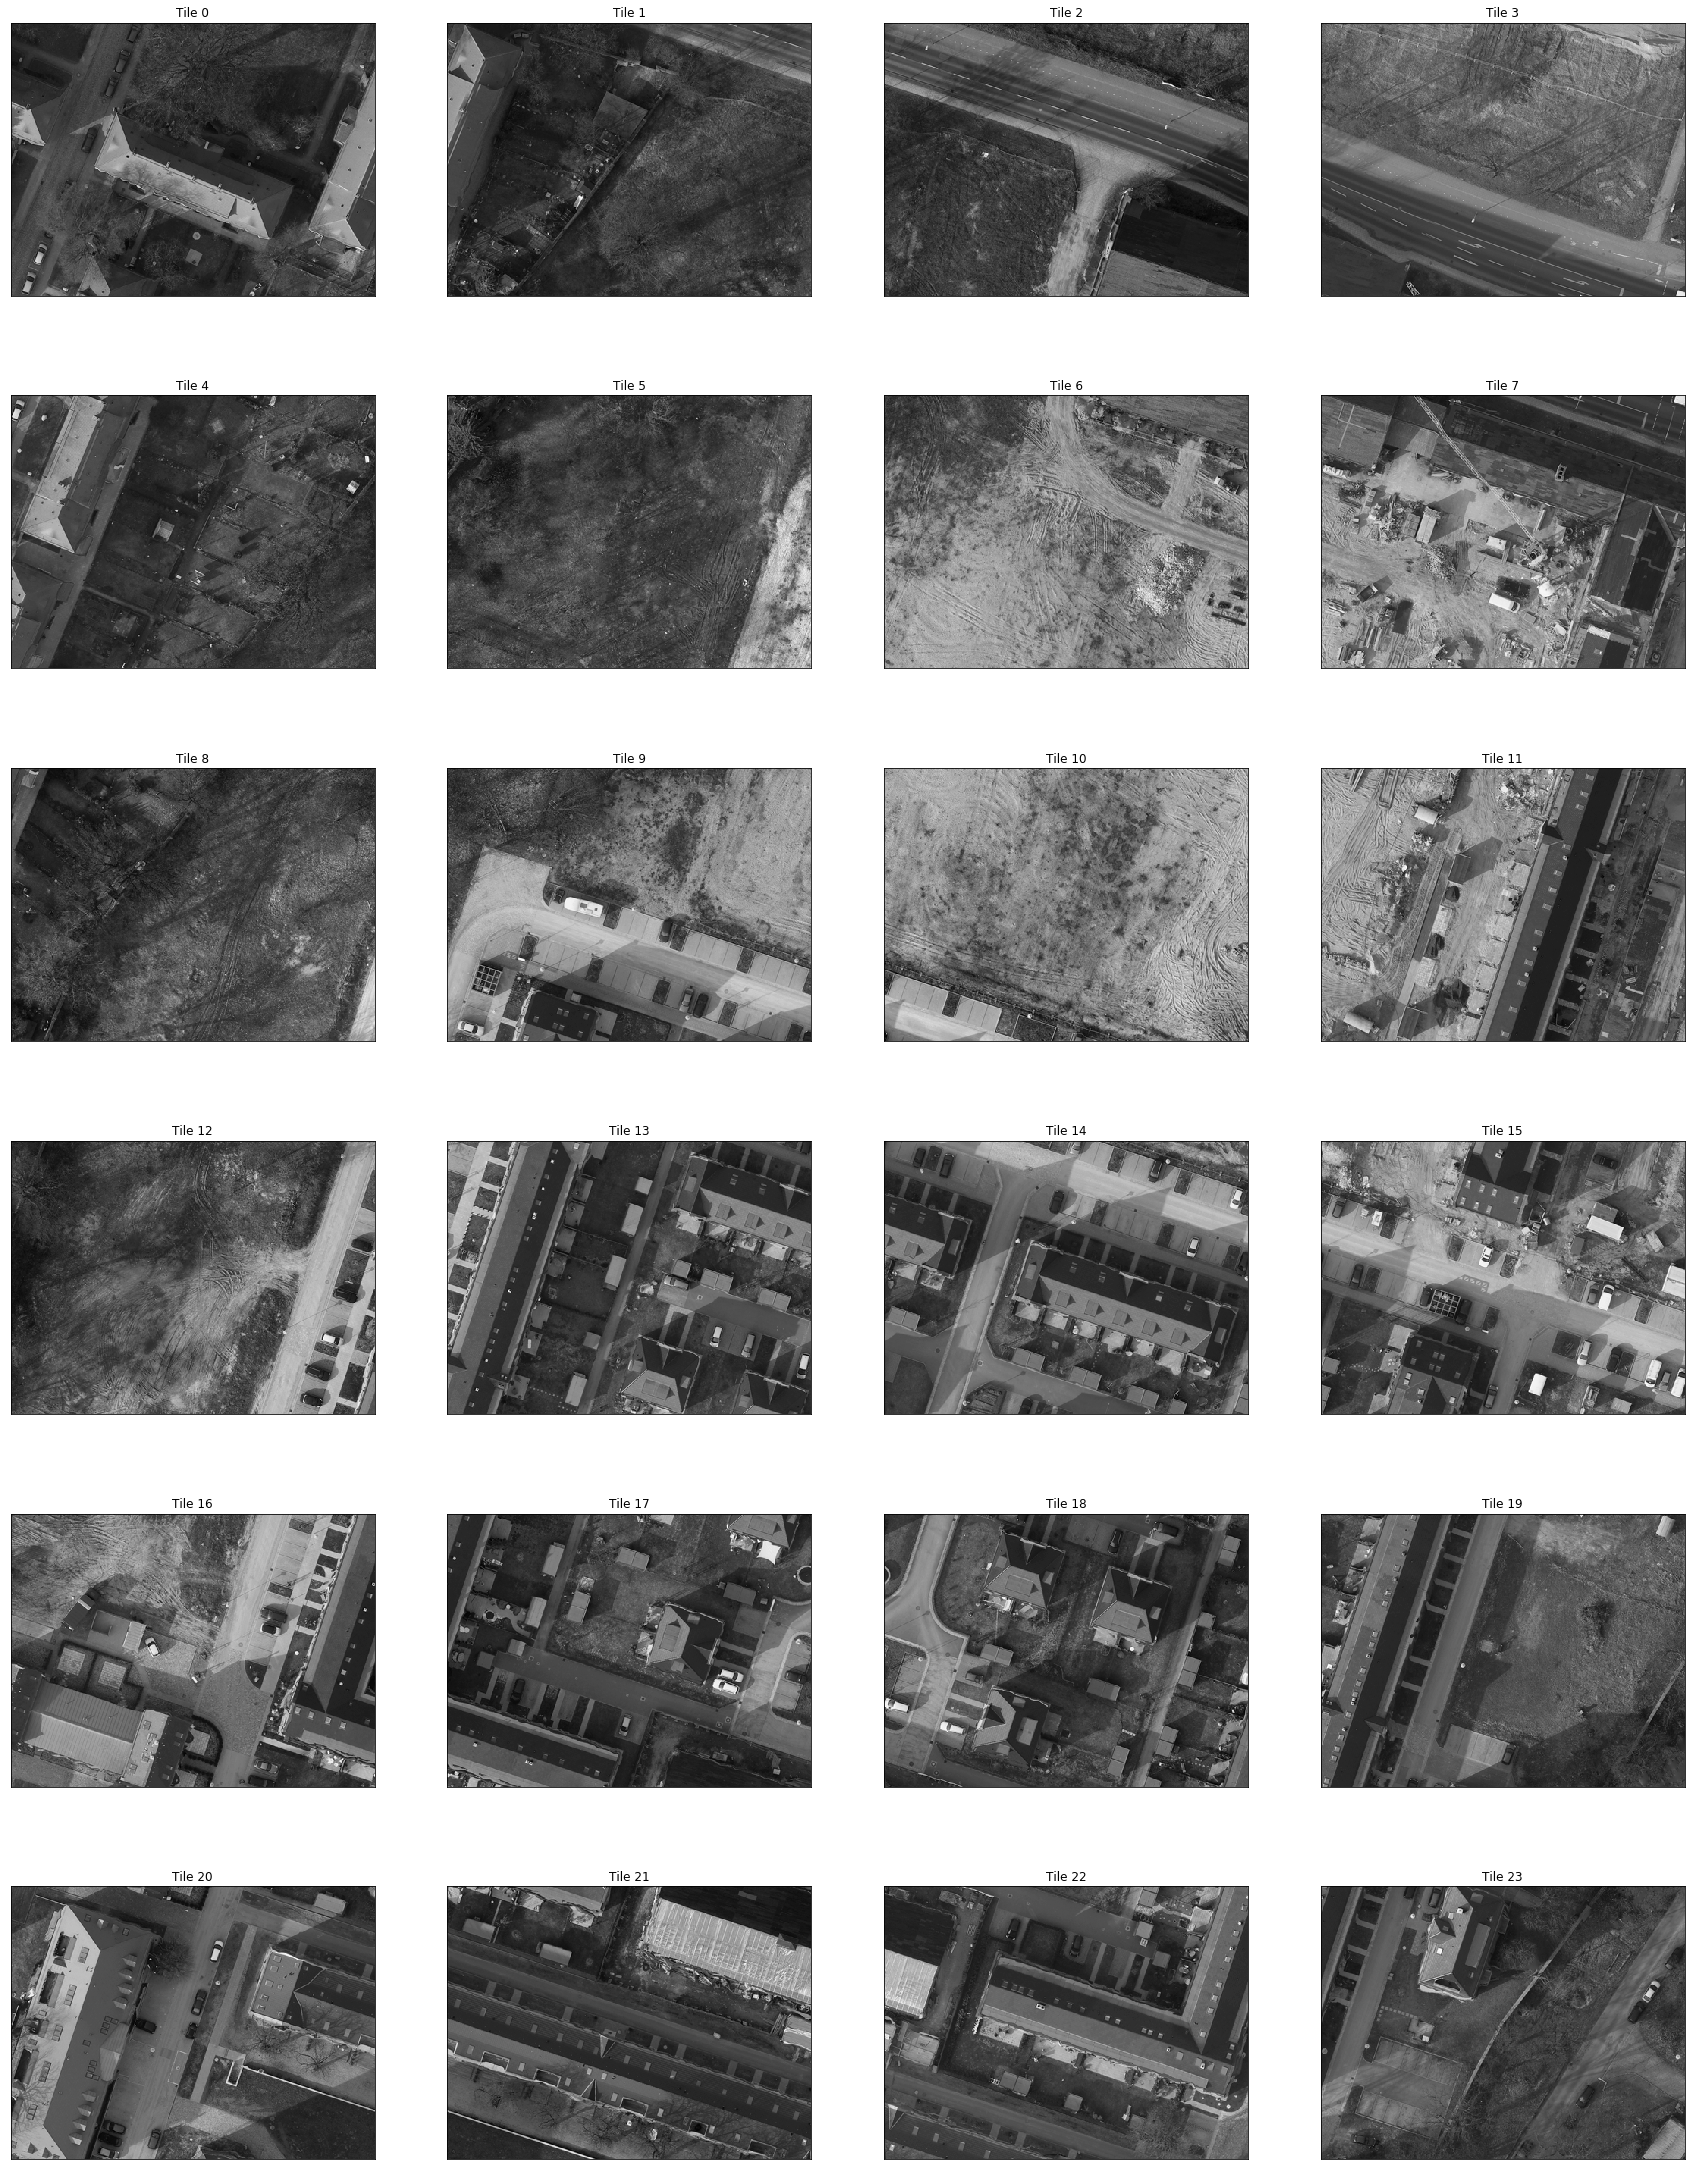

In [146]:
# preprocessing of training data
# read in training image
train = 'training_data/top_potsdam_2_10_RGB_Annotated_all.tif'

# visualize initial image
img_gray = cv2.imread(train, 0)
plt.imshow(img_gray, 'gray')
plt.title("Full initial image")
plt.show()

# read in image(s) as greyscale and show
roi,x,y = split_img(img_gray)

# show smaller images
plt.figure(figsize=(30,40))
for i in range(x*y):
    plt.subplot(x,y,i+1),plt.imshow(roi[i],'gray')
    plt.title("Tile "+str(i))
    plt.xticks([]),plt.yticks([])
plt.show()

### Region Growing Function

Adapted from https://github.com/Panchamy/RegionGrowing/blob/master/RegionGrowing.py



In [243]:
# function for creating a region from a seed (queens case)
def region_growing(img, seed, region_threshold = 0.1, 
                   neighbor_definition = 'rook', region_max = 35*17,
                   region_dim_max = 37, region_ratio = 0.5):
    
    # Parameters for region growing
    # how do we define a neighbor?
    if neighbor_definition == 'queen':
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1), (1,1), (-1,-1), (1,-1), (-1,1)]
    else:
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    region_size = 1
    intensity_difference = 0
    neighbor_points_list = []
    neighbor_intensity_list = []

    #Mean of the segmented region
    region_mean = img[seed]

    #Input image parameters
    height, width = img.shape
    # max image patch based on max car size

    #Initialize segmented output image
    segmented_img = np.zeros((height, width, 1), np.uint8)

    #Region growing until intensity difference becomes greater than certain threshold
    while (intensity_difference < region_threshold) & (region_size < region_max):
        #Loop through neighbor pixels
        for i in range(len(neighbors)):
            #Compute the neighbor pixel position
            x_new = seed[0] + neighbors[i][0]
            y_new = seed[1] + neighbors[i][1]

            #Boundary Condition - check if the coordinates are inside the image
            check_inside = (x_new >= 0) & (y_new >= 0) & (x_new < height) & (y_new < width)

            #Add neighbor if inside and not already in segmented_img
            if check_inside:
                if segmented_img[x_new, y_new] == 0:
                    neighbor_points_list.append([x_new, y_new])
                    neighbor_intensity_list.append(img[x_new, y_new])
                    segmented_img[x_new, y_new] = 255

        #Add pixel with intensity nearest to the mean to the region
        distance = abs(neighbor_intensity_list-region_mean)
        pixel_distance = min(distance)
        index = np.where(distance == pixel_distance)[0][0]
        segmented_img[seed[0], seed[1]] = 255
        region_size += 1

        #New region mean
        region_mean = (region_mean*region_size + neighbor_intensity_list[index])/(region_size+1)

        #Update the seed value
        seed = neighbor_points_list[index]
        #Remove the value from the neighborhood lists
        neighbor_intensity_list[index] = neighbor_intensity_list[-1]
        neighbor_points_list[index] = neighbor_points_list[-1]
    
    # !!! TODO: this is the biggest area of concern !!!
    # determine how square this is (how car-like)
    x_diff = (max(neighbor_points_list, key=lambda x: x[0])[0] - 
                min(neighbor_points_list, key=lambda x: x[0])[0])
    y_diff = (max(neighbor_points_list, key=lambda x: x[1])[1] - 
                min(neighbor_points_list, key=lambda x: x[1])[1])
    ratio = x_diff/y_diff
    
    # if ratio between these too is too great... 
    if ((ratio > 1.5 or ratio < 0.75) or
            x_diff > 37 or y_diff > 37):
        # then set the blob to zero
        segmented_img[:,:] = 0

    return segmented_img

### Verification Function

This function determines the accuracy of the segmentation effort, defined by 100*TP/(TP+FP+FN)

In [238]:
# function to determine how many cars were correctly identified in an image (raw #)
def check_result(seg, n, truth):
    
    # identify blobs - create matrix of blobs
    blobs = seg > 100 # change this value?
    blobs_labels = measure.label(blobs, background=0)
    unique,counts = np.unique(blobs_labels, return_counts = True)
    
    # total number of blobs identified
    num_blobs = len(unique) - 1

    # multiply blobs_labels by truth pixels
    if len(blobs.shape) == 3:
        mult = (blobs[:,:,0] * truth[n])
    elif len(blobs.shape) == 2:
        mult = (blobs * truth[n])
    else:
        print("Oh no! Error! Your `seg` input is faulty")

    # count number of cars detected
    unique,counts = np.unique(mult, return_counts = True)
    try:
        num_cars_found = dict(zip(unique, counts))[1]
    except:
        num_cars_found = 0
    
    # count number of cars total
    unique,counts = np.unique(truth[n], return_counts = True)
    try:
        num_cars = dict(zip(unique, counts))[1]
    except:
        num_cars = 0

    # accuracy: 100*tp/(tp+fn+fp)
    fp = num_blobs - num_cars_found
    fn = num_cars - num_cars_found
    accuracy = 100*num_cars_found/(num_cars_found + fp + fn)
    
    # return accuracy, num_blobs, num_cars (ABC)
    return accuracy, num_blobs, num_cars, num_cars_found

### Seed and Combination Function

The following functions determine the seeds to use for a random image and how images should be combined once the random seeds are set.  The more seeds, the more likely to find something - but more seeds obviously also require more processing time, which may not be feasible.

In [245]:
# find random seeds - up to 100 per image
def multiple_seeds(img, n_seeds = 100, region_threshold = 0.1, 
                   neighbor_definition = 'rook', region_max = 35*17):
    # initialize empty matrix
    multi_blob = np.zeros((tile_x, tile_y), np.uint8)

    for i in range(n_seeds):
        # select seed randomly
        seed = (random.randint(0,tile_x-1),random.randint(0,tile_y-1))

        # process region growing for single seed
        region = region_growing(img,seed, region_threshold, neighbor_definition, region_max)

        # add any regions identified to multi_blob matrix
        multi_blob += region[:,:,0]
    
    return multi_blob

2.5974025974025974 71 8


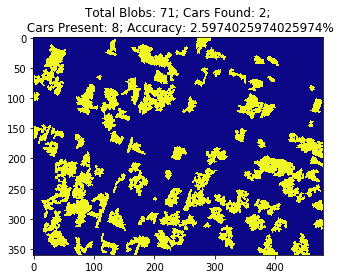

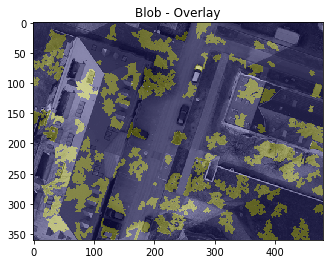

In [246]:
# test how well this did
n = 20
multi_blob = multiple_seeds(roi[n], 500, 0.05)
accuracy, blob, car, car_found = check_result(multi_blob, n, truth)
print(accuracy, blob, car)

# plot just blobs
plt.imshow(multi_blob, cmap="plasma")
plt.title("Total Blobs: "+str(blob)+
          "; Cars Found: "+str(car_found)+
          ";\n Cars Present: "+str(car)+
          "; Accuracy: "+str(accuracy)+"%")
plt.show()

# overlay over image
im2 = plt.imshow(roi[n], cmap='gray')
im = plt.imshow(multi_blob, cmap="plasma",alpha = 0.3)
plt.title('Blob - Overlay')
plt.show()

### Attempt on Gradient Image

What happens if the laplace transform is taken prior to running this algorithm?  Would that help or harm?  (Spoiler alert: it doesn't seem to make a significant difference)

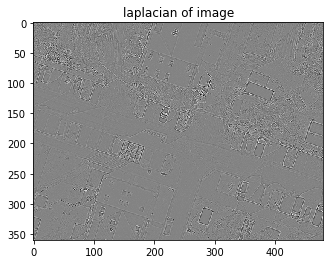

3.3333333333333335 47 15


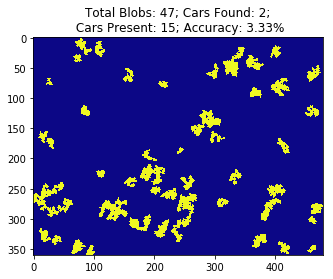

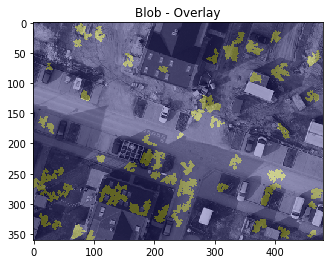

In [258]:
# try processing techniques on gradient image instead

# take laplacian of image
n = 15
laplace_image = cv2.Laplacian(roi[n],cv2.CV_64F)
plt.imshow(laplace_image, 'gray')
plt.title('laplacian of image')
plt.show()

# run processing on this
multi_blob = multiple_seeds(laplace_image, 100, 0.01)
accuracy, blob, car, car_found = check_result(multi_blob, n, truth)
print(accuracy, blob, car)

# plot just blobs
plt.imshow(multi_blob, cmap="plasma")
plt.title("Total Blobs: "+str(blob)+
          "; Cars Found: "+str(car_found)+
          ";\n Cars Present: "+str(car)+
          "; Accuracy: "+str(round(accuracy,2))+"%")
plt.show()

# overlay over image
im2 = plt.imshow(roi[n], cmap='gray')
im = plt.imshow(multi_blob, cmap="plasma",alpha = 0.3)
plt.title('Blob - Overlay')
plt.show()

### Attempt to Optimize Variables

There are a number of variables to optimize within this setup:
- number seed points* (range: 100 to 2500 by 100 - 25)
- vehicle patch size (region_max)
- segmentation threshold* (range: 0.001 to 0.5: [0.001, 0.01, 0.05, 0.1, 0.25, 0.5] - 6)
- maximum dimension of a region (region_dim_max)
- region ratio
- neighbor definition (queen vs rook)* (range: both - 2)

In order to do this, we're just going to brute force our way through a number of options and find the minimum of the resultant variable.  Since optimizing all of these variables at once would be computationally intensive, only the variables denoted with (*) will be addressed.

These will be tested against (which? how many?) tiles from the training dataset image.

Optimal outcome will be determined by the highest accuracy.  This should be an average of 5 runs, so that the initial random seed doesn't skew results (more would be better, but due to time...).

In [ ]:
# define variables to be addressed
test_seednum = range(100, 2500, 100)
test_threshold = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5]
#test_seednum = [100]
#test_threshold = [0.5]
n = 15

# optimize for rooks case
rook = np.zeros((len(test_seednum),len(test_threshold)))
for i in range(len(test_seednum)):
    for j in range(len(test_threshold)):
        # average accuracy
        avg_acc = 0
        # repeat five times for each set of parameter for a given image
        for k in range(5):
            multi_blob = multiple_seeds(roi[n], test_seednum[i], test_threshold[j], 'rook')
            accuracy, blob, car, car_found = check_result(multi_blob, n, truth)
            avg_acc += accuracy/5
        # place average accuracy in matrix
        rook[i,j] = avg_acc
        
# optimize for queen's case
queen = np.zeros((len(test_seednum),len(test_threshold)))
for i in range(len(test_seednum)):
    for j in range(len(test_threshold)):
        # average accuracy
        avg_acc = 0
        # repeat five times for each set of parameter for a given image
        for k in range(5):
            multi_blob = multiple_seeds(roi[n], test_seednum[i], test_threshold[j], 'queen')
            accuracy, blob, car, car_found = check_result(multi_blob, n, truth)
            avg_acc += accuracy/5
        # place average accuracy in matrix
        queen[i,j] = avg_acc

In [277]:
print(np.amax(rook))
print(np.argmax(rook))
ind = np.unravel_index(np.argmax(rook, axis=None), rook.shape)
print(ind)
rook[ind]

22.782420686508512
103
(17, 1)


22.782420686508512

In [278]:
rook.shape

(24, 6)

In [279]:
rook[0,:]

array([3.65839605, 1.85968696, 2.51695923, 2.07309942, 2.85814326,
       1.29844961])

In [283]:
rook[17,:]

array([17.6007326 , 22.78242069, 16.83213863, 19.03958724, 19.87004409,
       20.76999102])

### Example of Car Roof Segmentation (true positive)

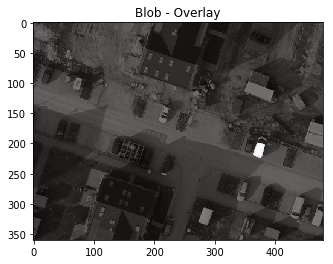

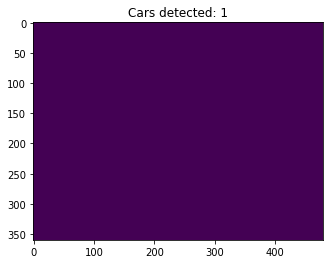

In [160]:
# test examples
n = 15
seed = (215, 370)
seg = region_growing(roi[n], seed)

# plot overlay on top of image
im2 = plt.imshow(roi[n], cmap='gray')
im = plt.imshow(seg[:,:,0], cmap="hot",alpha = 0.5)
plt.title('Blob - Overlay')
plt.show()

# identify blobs - create matrix of blobs
blobs = seg > 100 # change this value
blobs_labels = measure.label(blobs, background=0)

# number of blobs?

# multiply blobs_labels by truth pixels
mult = (blobs[:,:,0] * truth[n])

# count number of ones
unique,counts = np.unique(mult, return_counts = True)
cars = dict(zip(unique, counts))[1]

# count number of blobs in p
plt.imshow(mult)
plt.title("Cars detected: " + str(cars))
plt.show()

### Example of Bad Segmentation (false positive)

This bad example of segmentation clearly shows the need for a better metric for what counts as a "good" blob.  While the bounding box of the "blob", shown in white, meets the ratio requirements, the blob clearly snakes within the prescribed area and does not meet the intended shape requirements.

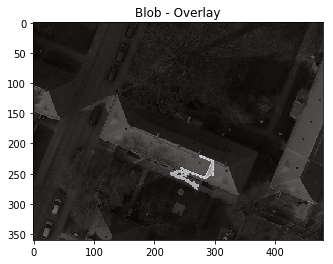

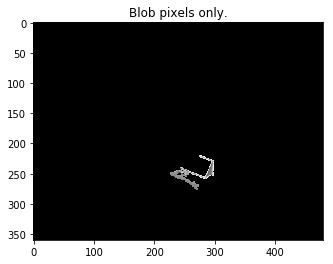

In [225]:
# test examples
# n = 1
# seed = (100,100)

n = 0
seed = (250, 290)
seg = region_growing(roi[n], seed)

# plot overlay on top of image
im2 = plt.imshow(roi[n], cmap='gray')
im = plt.imshow(seg[:,:,0], cmap="hot",alpha = 0.5)
plt.title('Blob - Overlay')
plt.show()

# identify blobs - create matrix of blobs
blobs = seg > 100 # change this value
blobs_labels = measure.label(blobs, background=0)

# multiply blobs_labels by truth pixels
mult = blobs[:,:,0] * roi[n]

# count number of blobs in p

# once you pick a seed point, how do you decide if it's a car? BLOB SHAPE
plt.imshow(mult,'gray')
plt.title("Blob pixels only.")
plt.show()

### Example of No Segmentation (true negative)

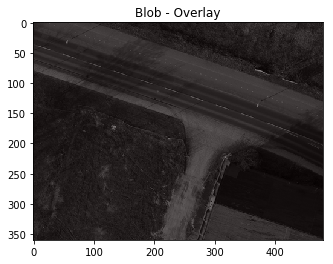

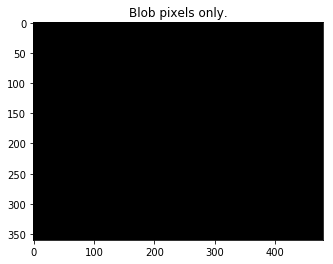

In [141]:
# test examples
n = 2
seed = (100,100)
seg = region_growing(roi[n], seed)

# plot overlay on top of image
im2 = plt.imshow(roi[n], cmap='gray')
im = plt.imshow(seg[:,:,0], cmap="hot",alpha = 0.5)
plt.title('Blob - Overlay')
plt.show()

# identify blobs - create matrix of blobs
blobs = seg > 100 # change this value
blobs_labels = measure.label(blobs, background=0)

# multiply blobs_labels by truth pixels
mult = blobs[:,:,0] * roi[n]

# count number of blobs in p

# once you pick a seed point, how do you decide if it's a car? BLOB SHAPE
plt.imshow(mult,'gray')
plt.title("Blob pixels only.")
plt.show()

In [ ]:
# test performance on Test dataset

# read in test dataset
test_data = 'testing_data/top_potsdam_2_14_RGB_Annotated_all.tif'
img_gray1 = cv2.imread(test_data, 0)
test_data,x1,y1 = split_img(img_gray1)

# read in test truth
test_truth = 'testing_data/top_potsdam_2_14_RGB_Annotated_cars.tif'

# read in image(s) as greyscale and show
img_gray2 = cv2.imread(test_truth, 0)/76
test_truth,x2,y2 = split_img(img_gray2)

# run algorithm for optimal variables and test
accuracy = []
for n in range(x1*y1):
    multi_blob = multiple_seeds(test_data[n], 1800, 0.01, 'rook')
    acc, blob, car, car_found = check_result(multi_blob, n, test_truth)
    accuracy.append(acc)

    